In [75]:
import scipy.io
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from utility_functions import (
    BIN_LABELS,
    get_data_info,
    clean_ncp,
    process_mat_files_list,
    process_mat_files,
    create_plotly_heatmaps,
    create_heatmaps_w_boxes,
    unzip_mat_files,
)


In [76]:
zip_folder = r"DATA\\w_step_XRAY_SWEEP_10mA_2PE.zip"
parent_dir = os.path.dirname(zip_folder)
# print(f"{parent_dir = }")
mat_files = unzip_mat_files(zip_folder)

In [77]:
import numpy as np

outside_borders = {"top": 4, "bot": 185, "left": 4, "right": 12}

x_left, x_right = 18, 36
edges_y = np.array([0, 19, 41, 64, 86, 108, 129, 152, 174])
num_boxes = len(edges_y)
# print(f"{num_boxes = }")
diffs_y = np.diff(edges_y) # not used?
y_length = 15

y_borders = {
    i: {"top": edges_y[i] + 2, "bot": edges_y[i] + y_length} for i in range(num_boxes)
}
y_borders[num_boxes] = {"top": outside_borders["top"], "bot": outside_borders["bot"]}

# last box is the outside the W-PETG test piece
x_borders = {i: {"left": x_left, "right": x_right} for i in range(len(edges_y))}
x_borders[num_boxes] = {"left": outside_borders["left"], "right": outside_borders["right"]}


num_boxes = 9


In [78]:
for i, bin_id in enumerate([0,1,2,3,4,5,6]):
    
    _, _, full_count_map = process_mat_files_list(bin_id, mat_files)
    
    full_count_map = clean_ncp(full_count_map, verbose=False)

    
    color_min, color_max = np.percentile(full_count_map, [1, 99.5])

    heatmap_fig = create_heatmaps_w_boxes(full_count_map, 
                                         y_borders, 
                                         x_borders, 
                                         color_range=[color_min, color_max],)
    
    heatmap_fig.update_layout(title=f"{BIN_LABELS[bin_id]}")

    heatmap_fig.show()


## Equations

In [79]:
DENSITY = 4.0 #g/cm^3 according to Prusa's article

def Intensity(x, I0, mu, offset):
    return I0 * np.exp(-mu * x) + offset

def HVL(mu):
    # ln(2)/mu
    return np.log(2)/mu 

def T_mean_to_mu(T_mean, x):
    return -np.log(T_mean)/x

def MFP(mu):
    return 1/mu

def mass_mu(mu, DENSITY):
    return mu/DENSITY

print(HVL(27.11))
print(HVL(4.95))
print(HVL(36.23))

0.025567952067869618
0.14002973344645359
0.019131857040020572


## Data extraction

In [80]:
from scipy.optimize import curve_fit

# thickness = [10, 5, 4, 3, 2.5, 2, 1.5, 1, 0.5]
thickness = [9.91, 4.98, 4.01, 3.03, 2.65, 2.05, 1.65, 1.05, 0.65, 0]

zip_folder = r"DATA\\w_step_XRAY_SWEEP_10mA_2PE.zip" 
# zip_folder = r"DATA\\10_XRAY_SWEEP_10mA_2PE.zip"

def calculate_counts_in_box(zip_folder, 
                            y_borders, 
                            x_borders, 
                            thickness,
                            save_csv=True):
    
    
    mat_files = unzip_mat_files(zip_folder)
    
    df = pd.DataFrame() # create an empty dataframe to store the results

    bin_range = [0,1,2,3,4,5,6]
    for i, bin_id in enumerate(bin_range):
        df_bin = pd.DataFrame()
        
        _, _, full_count_map = process_mat_files_list(bin_id, mat_files)
        full_count_map = clean_ncp(full_count_map)
        box_mean, box_std, box_median = [], [], []
        for key in y_borders:
            # print(key)
            y_top, y_bot = y_borders[key]["top"], y_borders[key]["bot"]
            x_left, x_right = x_borders[key]["left"], x_borders[key]["right"]
            box_count = full_count_map[y_top:y_bot, x_left:x_right]
            box_mean.append(np.mean(box_count))
            box_std.append(np.std(box_count))
            box_median.append(np.median(box_count))
        
        df_bin["bin_id"] = np.repeat(bin_id, len(thickness))
        df_bin["bin_label"] = np.repeat(BIN_LABELS[bin_id], len(thickness))
        df_bin["thickness"] = thickness
        df_bin["box_mean"] = box_mean
        df_bin["box_std"] = box_std
        df_bin["box_median"] = box_median
        df_bin = df_bin.round(3)
        df = pd.concat([df, df_bin])
        
    if save_csv:
        folder_name = zip_folder.replace(".zip", "")
        df.to_csv(folder_name+".csv", index=False)
    
    return df

df = calculate_counts_in_box(zip_folder, 
                             y_borders, 
                             x_borders, 
                             thickness, 
                             save_csv=True)

print(df)


    bin_id    bin_label  thickness  box_mean  box_std  box_median
0        0       20 kev       9.91     4.240    1.873       3.970
1        0       20 kev       4.98     4.611    1.996       4.378
2        0       20 kev       4.01     5.837    2.631       5.698
3        0       20 kev       3.03     8.556    3.693       8.300
4        0       20 kev       2.65    10.627    5.304       9.814
..     ...          ...        ...       ...      ...         ...
5        6  Sum CC1-CC5       2.05   201.500   15.152     201.652
6        6  Sum CC1-CC5       1.65   296.517   20.745     295.704
7        6  Sum CC1-CC5       1.05   526.334   34.531     527.173
8        6  Sum CC1-CC5       0.65   830.803   53.572     833.467
9        6  Sum CC1-CC5       0.00  1877.110   50.789    1880.718

[70 rows x 6 columns]


### Calculate transmission by dividing with air norm values

In [109]:
df_wstep = pd.read_csv("DATA\\w_step_XRAY_SWEEP_10mA_2PE.csv")
df_airnorm = pd.read_csv("DATA\\10_XRAY_SWEEP_10mA_2PE.csv")

df_T = df_wstep.copy()
df_T["box_mean_air"] = df_airnorm["box_mean"]
df_T["T_mean"] = df_wstep["box_mean"]/df_airnorm["box_mean"]  
df_T["T_mean"] = df_T["T_mean"].round(3)
df_T.to_csv(r"DATA\\T_mean.csv", index=False)

### Calculate fit parameters

In [84]:
from scipy.optimize import curve_fit

df_params = pd.DataFrame()
bin_range = [0,1,2,3,4,5,6]
for i, bin_id in enumerate(bin_range):
    df_bin = df_T[df_T["bin_id"] == bin_id]
    popt, pcov = curve_fit(Intensity, df_bin["thickness"], df_bin["T_mean"], p0=[1, 0.1, 0])
    I0, mu, offset = popt
    I0_err, mu_err, offset_err = np.sqrt(np.diag(pcov))
    hvl, mfp, mu_mass = HVL(mu), MFP(mu), mass_mu(mu, DENSITY)
    
    row = pd.DataFrame({
        "bin_id": bin_id,
        "bin_label": BIN_LABELS[bin_id],
        "I0 [counts]": I0,
        "mu [mm^-1]": mu,
        "offset [counts]": offset,
        "I0_err": I0_err,
        "mu_err": mu_err,
        "offset_err": offset_err,
        "HVL [mm]": hvl,
        "MFP [mm]": mfp,
        "mu_mass": mu_mass
    }, index=[0])
    
    if bin_id == 0:
        df_params = row
    else:
        df_params = pd.concat([df_params, row])
        
df_params = df_params.round(3)
df_params.to_csv(r"DATA\\PARAMS-2024-10-23.csv", index=False) 

    

### Plotting

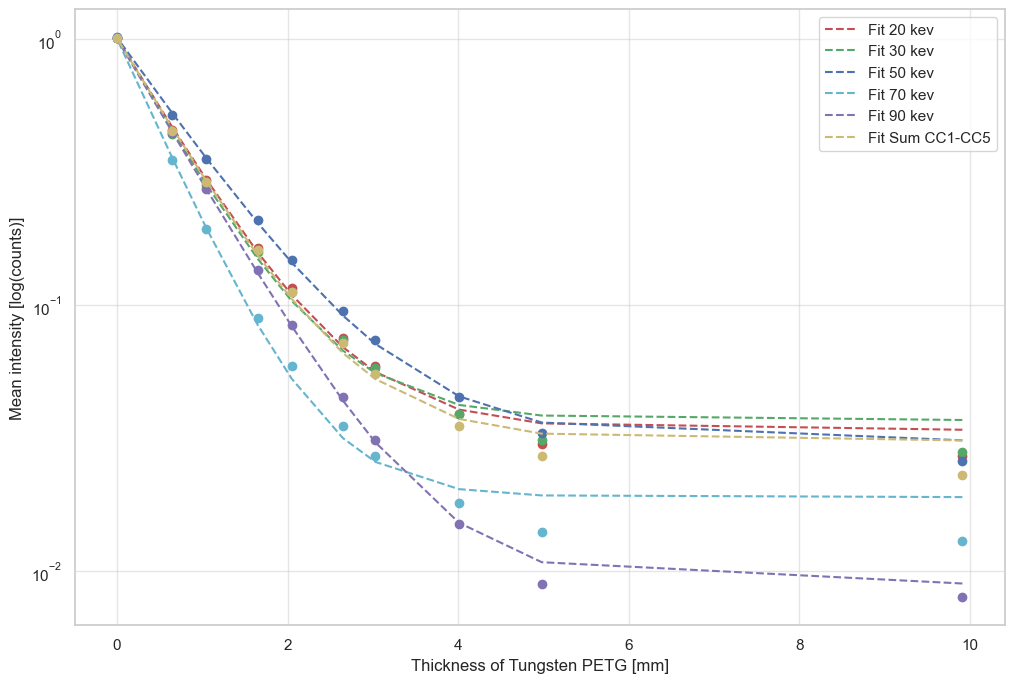

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bin_range = [0,1,2,3,4,6]
for i, bin_id in enumerate(bin_range): # skip bin 5

    df_bin = df_T[df_T["bin_id"] == bin_id]
    start_idx = 0
    thickness = df_bin["thickness"][start_idx:].values 
    T_mean = df_bin["T_mean"][start_idx:].values

    I0_fit = df_params[df_params["bin_id"]==bin_id]["I0 [counts]"].values
    mu_fit = df_params[df_params["bin_id"]==bin_id]["mu [mm^-1]"].values
    offset_fit = df_params[df_params["bin_id"]==bin_id]["offset [counts]"].values

    # print(f"{thickness = }")
    # print(f"{T_mean = }")
    # print(f"{Intensity(thickness, I0_fit, mu_fit, offset_fit) = }")

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    ax.plot(thickness, T_mean, "o", color = colors[i],)
    
    ax.plot(thickness, Intensity(thickness, I0_fit, mu_fit, offset_fit), 
            "--",
            label=f"Fit {BIN_LABELS[bin_id]}",
            color = colors[i])
    

    # make plots look nice 
    ax.set_xlabel("Thickness of Tungsten PETG [mm]")
    ax.set_ylabel("Mean intensity [counts]")
    ax.legend()
    ax.grid(True, alpha=0.5)
    if log_scale:=1:
        ax.set_yscale("log")  # Set y-axis to log scale
        ax.set_ylabel("Mean intensity (counts) - log scale")
plt.show()

### Notes about the data

cc_struct.data.cc_data(D1, D2, D3, D4, D5). The value designated for each of the 5 dimensions (D1-D5) are as follows:

D1: either tube currents (for uniformity) or the scan steps (for energy/spectral data). This will be a singleton for all other tests and can be squeezed/removed from the array;

D2: Specify which energy bin. 13 bins total (SEC0-SEC5, CC0-CC5, EC);

D3: capture views. Singleton for energy tests with one view (can be squeezed/removed);

D4: pixel rows

D5: pixel columns

So for uniformity the value inserted in D1 (1-12) would give access to the different tube current that were measured (0-25 mA), while for a spectral scan the values correspond to threshold settings in a scan (these values are in DAC values, i.e. non-energy calibrated - the standard gain and offset that can be used to get a first approximation to energy calibration should you want to do that are 0.71keV/DAC level and 4keV respectively).

D2 specify which energy bin we are addressing. The energies are designated 0-5 (i.e. 30-45, 45-60, 60-75, 75-90, 90-105, and 105 keV and up for your threshold settings). SEC or CC refers to charge sharing corrected and non-charge sharing corrected data respectively, and EC are the counts above the lowest threshold in the system.

D3 specify which temporal slice of the data we are addressing, and D4, and D5 pixel row and column to designate specific pixel.
